# Image Classification 

## Task description

Task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset (https://www.kaggle.com/code/turusanasak/cats-and-dogs). The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
from torchvision.datasets.utils import check_integrity

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torchsummary import summary


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading one example for each object type from the dataset
Show some images and labels of dataset

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Truncated File Read
  warnings.warn(str(msg))


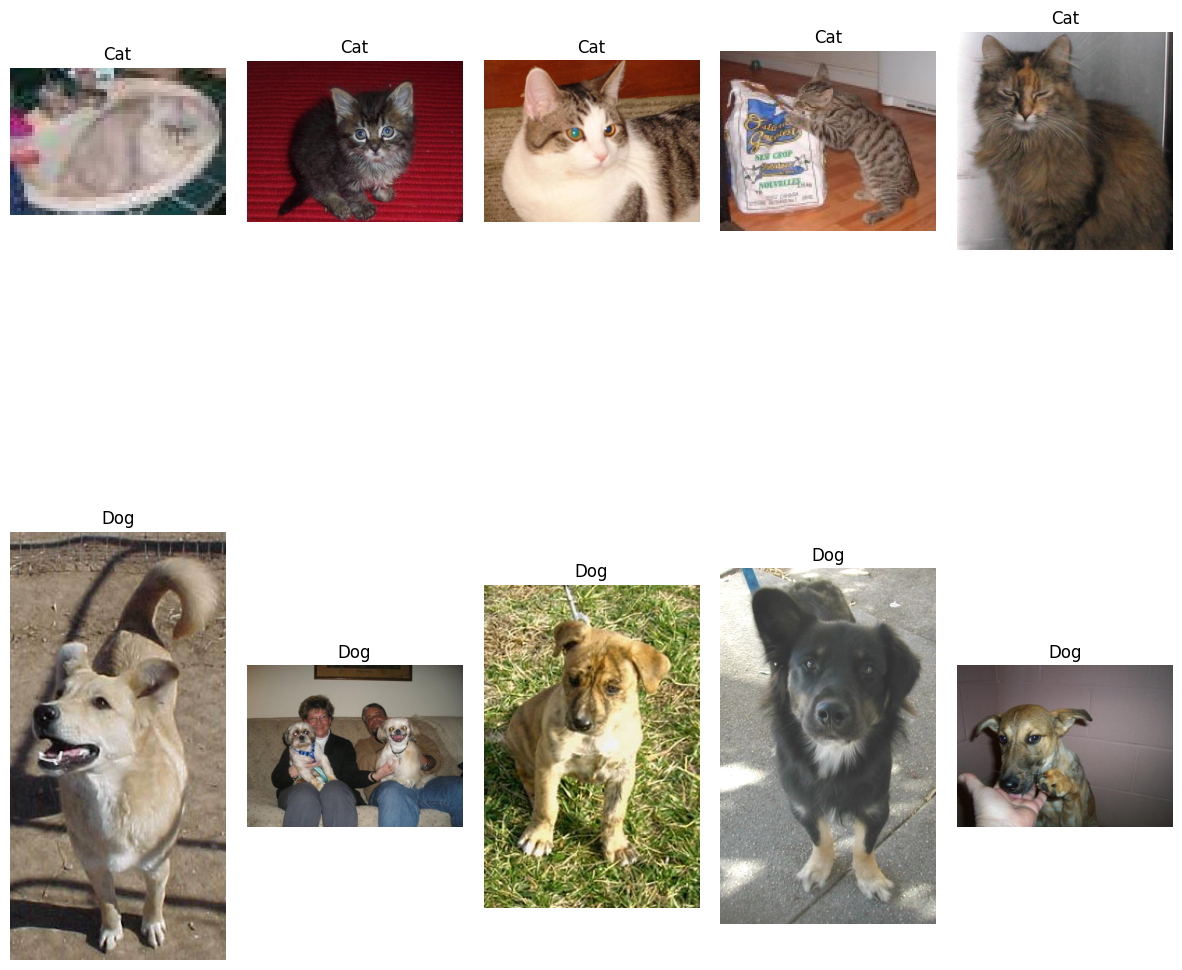

In [2]:
# Define the path to your dataset's main folder
dataset_folder = '/home/preeti/Downloads/kagglecatsanddogs_5340/PetImages'

# Create lists to store images and labels
X = []  # List to store images
Y = []  # List to store labels

# Define a custom dataset loader class to filter out corrupted images
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        self._filter_corrupted_images()

    def _filter_corrupted_images(self):
        to_remove = []
        for i, (path, target) in enumerate(self.samples):
            try:
                with open(path, 'rb') as f:
                    Image.open(f)
            except (OSError, EOFError, Image.DecompressionBombError):
                to_remove.append(i)

        for idx in reversed(to_remove):
            self.samples.pop(idx)

# Use the custom dataset loader to filter out corrupted images
dataset = CustomImageFolder(dataset_folder, transform=None)  # No preprocessing transform

# Load and store each image and its corresponding label (subfolder name)
for path, target in dataset.samples:
    with Image.open(path) as image:
        # Convert to RGB format
        image = image.convert('RGB')
        label = os.path.basename(os.path.dirname(path))  # Get the subfolder name as the label
        X.append(np.array(image))  # Convert PIL image to NumPy array
        Y.append(label)

# Shuffle the images within each class
zipped_data = list(zip(X, Y))
random.shuffle(zipped_data)
X, Y = zip(*zipped_data)

# Display images of each class in a neat grid with reduced gap
class_names = list(set(Y))  # Get unique class names
num_examples_per_class = 5  # Number of examples to show for each class

num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, num_examples_per_class, figsize=(15, 15))

for i, class_name in enumerate(class_names):
    class_images = [X[j] for j in range(len(X)) if Y[j] == class_name]
    for j in range(min(num_examples_per_class, len(class_images))):
        axes[i, j].imshow(class_images[j])
        axes[i, j].set_title(class_name)
        axes[i, j].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


#### Splitting the dataset

In [3]:

# Convert labels to numeric values
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the dataset into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=1 - train_ratio, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)


#### Pre-processing the dataset (data loader with transformations)

In [4]:

# Define data transformations for pre-processing
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL image
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.RandomHorizontalFlip(),  # Augmentation: Randomly flip images horizontally
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),

    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL image
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Create custom dataset classes for train, validation, and test
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Create DataLoader instances for train, validation, and test sets
train_dataset = CustomDataset(X_train, Y_train, transform=train_transform)
val_dataset = CustomDataset(X_val, Y_val, transform=test_transform)  # For validation, use the test_transform
test_dataset = CustomDataset(X_test, Y_test, transform=test_transform)

batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#### Check the number of images and class balances in the  train, validation and test set

In [5]:
# Check the number of images and class balances in each set
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# Class balances in the train set
train_classes, train_counts = np.unique(Y_train, return_counts=True)
train_class_balance = dict(zip(train_classes, train_counts))
print("Class balance in the train set:")
print(train_class_balance)

# Class balances in the validation set
val_classes, val_counts = np.unique(Y_val, return_counts=True)
val_class_balance = dict(zip(val_classes, val_counts))
print("Class balance in the validation set:")
print(val_class_balance)

# Class balances in the test set
test_classes, test_counts = np.unique(Y_test, return_counts=True)
test_class_balance = dict(zip(test_classes, test_counts))
print("Class balance in the test set:")
print(test_class_balance)

Number of training images: 17498
Number of validation images: 3750
Number of test images: 3750
Class balance in the train set:
{0: 8747, 1: 8751}
Class balance in the validation set:
{0: 1853, 1: 1897}
Class balance in the test set:
{0: 1899, 1: 1851}


In [6]:
# Check the number of images and class balances in each set
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# Class balances in the train set
train_classes, train_counts = np.unique(Y_train, return_counts=True)
train_class_balance = dict(zip(train_classes, train_counts))
train_class_labels = label_encoder.inverse_transform(train_classes)  # Convert encoded labels back to class labels
train_class_balance_with_labels = dict(zip(train_class_labels, train_counts))
print("Class balance in the train set:")
print(train_class_balance_with_labels)

# Class balances in the validation set
val_classes, val_counts = np.unique(Y_val, return_counts=True)
val_class_balance = dict(zip(val_classes, val_counts))
val_class_labels = label_encoder.inverse_transform(val_classes)  # Convert encoded labels back to class labels
val_class_balance_with_labels = dict(zip(val_class_labels, val_counts))
print("Class balance in the validation set:")
print(val_class_balance_with_labels)

# Class balances in the test set
test_classes, test_counts = np.unique(Y_test, return_counts=True)
test_class_balance = dict(zip(test_classes, test_counts))
test_class_labels = label_encoder.inverse_transform(test_classes)  # Convert encoded labels back to class labels
test_class_balance_with_labels = dict(zip(test_class_labels, test_counts))
print("Class balance in the test set:")
print(test_class_balance_with_labels)


Number of training images: 17498
Number of validation images: 3750
Number of test images: 3750
Class balance in the train set:
{'Cat': 8747, 'Dog': 8751}
Class balance in the validation set:
{'Cat': 1853, 'Dog': 1897}
Class balance in the test set:
{'Cat': 1899, 'Dog': 1851}


## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found.")

# Load the pre-trained ResNet18 model
pretrained_model = torchvision.models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

GPU is available.


#### Summary of the given pre-trained model

In [16]:
# summary of the pre-trained model
summary(pretrained_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
# Verify the number of samples in X_test and Y_test
num_test_samples = len(X_test)
num_test_labels = len(Y_test)

# Print the number of samples and labels
print(f"Number of test samples: {num_test_samples}")
print(f"Number of test labels: {num_test_labels}")

# Verify if the number of samples and labels match
if num_test_samples == num_test_labels:
    print("The number of samples and labels match.")
else:
    print("The number of samples and labels do not match.")

Number of test samples: 3750
Number of test labels: 3750
The number of samples and labels match.


In [18]:
# Modify the final classification layer for two classes
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 2)
pretrained_model.to(device)

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Move input data to the device
            labels = labels.to(device)  # Move labels to the device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(pretrained_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 49.33%


#### Implement the new architecture with less parameter

In [19]:

model = pretrained_model
model = model.to(device) 
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Summary of the new architecture

In [20]:
# summary of the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 3. Training

#### Define your loss function

In [21]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

#### Define your optimizer

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

#### Train your network

In [23]:
# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.1)

# Training and validation loops with early stopping
num_epochs = 10
best_model_state = None
best_accuracy = 0.0
early_stopping_patience = 3
early_stopping_counter = 0
train_losses = []  # Store training losses
train_accuracies = []  # Store training accuracies
val_losses = []  # Store validation losses
val_accuracies = []  # Store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    total_train_correct = 0  # Initialize total correct predictions for training
    total_train_samples = 0  # Initialize total samples for training

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        # Calculate the number of correct predictions and total samples for training
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    # Calculate training accuracy within the training loop
    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * total_train_correct / total_train_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    total_val_correct = 0  # Initialize total correct predictions for validation
    total_val_samples = 0  # Initialize total samples for validation

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss = running_val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = 100 * total_val_correct / total_val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Place scheduler.step(val_loss) here
    scheduler.step(val_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_state = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Save the best model
torch.save(best_model_state, 'custom_resnet18_best.pth')


Epoch [1/10] - Training Loss: 0.0791, Training Accuracy: 96.79%, Validation Loss: 0.0361, Validation Accuracy: 98.53%
Epoch [2/10] - Training Loss: 0.0402, Training Accuracy: 98.45%, Validation Loss: 0.0329, Validation Accuracy: 98.85%
Epoch [3/10] - Training Loss: 0.0336, Training Accuracy: 98.77%, Validation Loss: 0.0452, Validation Accuracy: 98.43%
Epoch [4/10] - Training Loss: 0.0273, Training Accuracy: 99.00%, Validation Loss: 0.0362, Validation Accuracy: 98.48%
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.
Epoch [5/10] - Training Loss: 0.0223, Training Accuracy: 99.16%, Validation Loss: 0.0376, Validation Accuracy: 98.67%
Early stopping triggered.


## 4. Evaluation and Testing
Load the trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [24]:
# Load the best model for evaluation
model.load_state_dict(best_model_state)

# Evaluate on the test set
model.eval()
test_losses = 0.0
correct = 0
total = 0
test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_losses += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_predictions.extend(predicted.tolist())

# Calculate the test accuracy
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_losses:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 2.6761, Test Accuracy: 98.24%


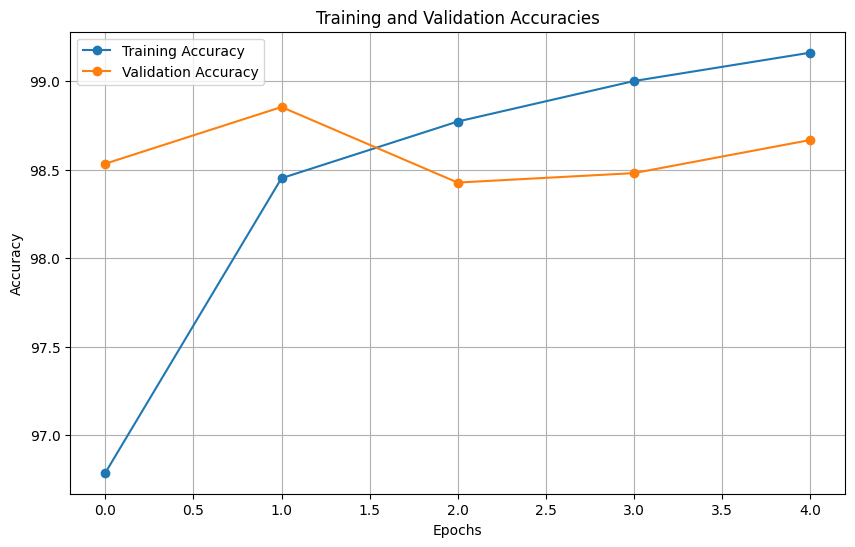

In [25]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

#### Show the test accuracy next to the training and validation

In [26]:


# Display training, validation, and test accuracy
print(f'Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Training Accuracy: 99.16%, Validation Accuracy: 98.67%, Test Accuracy: 98.24%


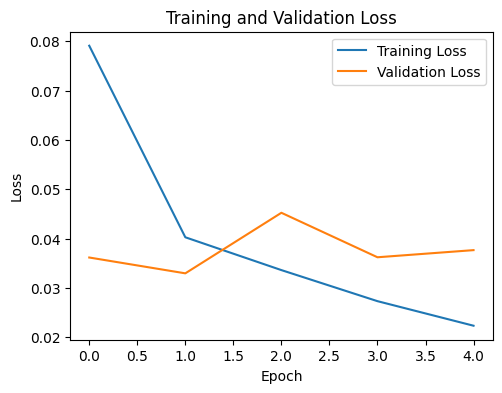

In [27]:
# Show the loss on training and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion matrix

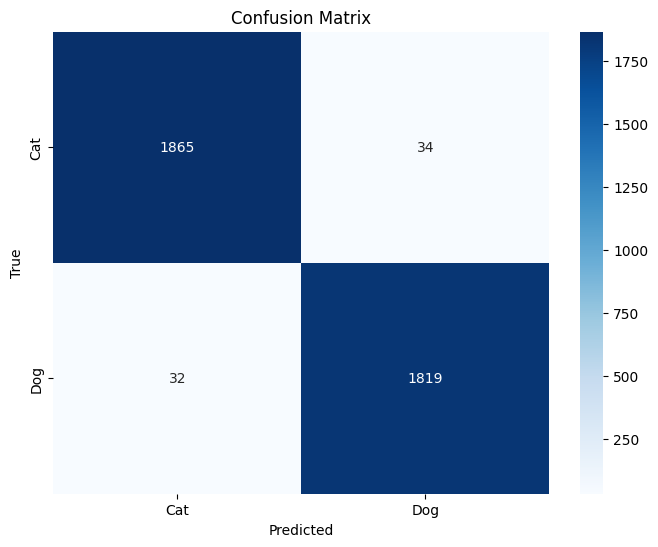

In [28]:
# Decode the labels to get original class labels
original_class_labels = label_encoder.inverse_transform(Y_test)

# Create the confusion matrix
true_labels = [label for label in Y_test]
predicted_labels = [label for label in test_predictions]
confusion = confusion_matrix(true_labels, predicted_labels)


# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Show some predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


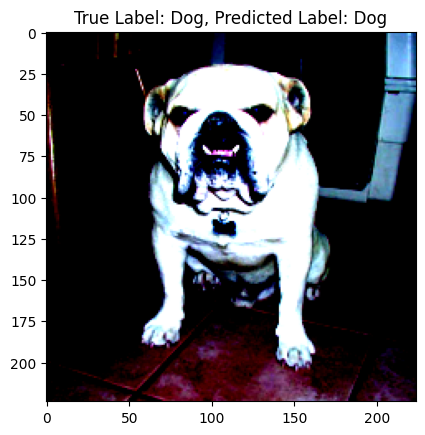

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


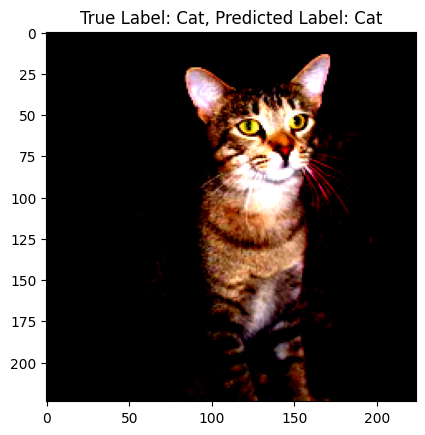

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


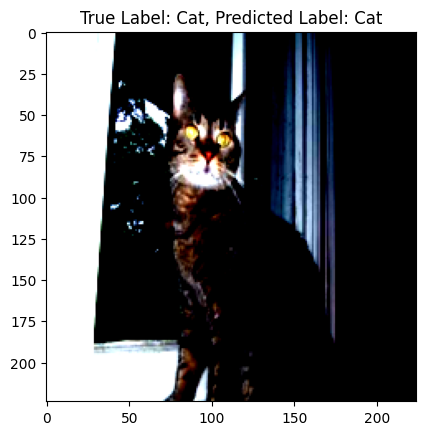

In [40]:
# Show some predictions on the test set
num_samples_to_show = 3

for i in range(num_samples_to_show):
    index = np.random.randint(len(test_loader.dataset))
    input_data, true_label = test_loader.dataset[index]
    input_data = input_data.unsqueeze(0).to(device)
    output = model(input_data)
    _, predicted_label = torch.max(output, 1)

    # Decode the labels to get original class labels
    true_label = label_encoder.inverse_transform([true_label.item()])[0]
    predicted_label = label_encoder.inverse_transform([predicted_label.item()])[0]

    # Display the image
    plt.figure()
    plt.imshow(input_data.cpu().squeeze().numpy().transpose((1, 2, 0)))
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()

#### Missed predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Missed Predictions:
Sample 1
True Label: Cat, Predicted Label: Dog


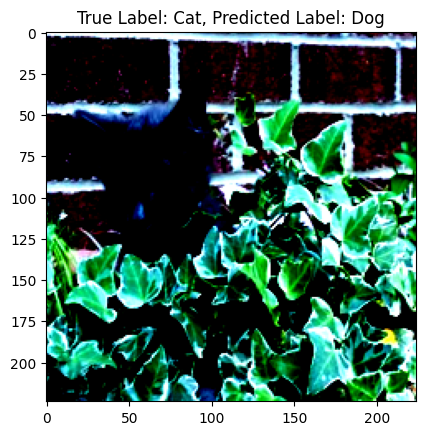

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 2
True Label: Dog, Predicted Label: Cat


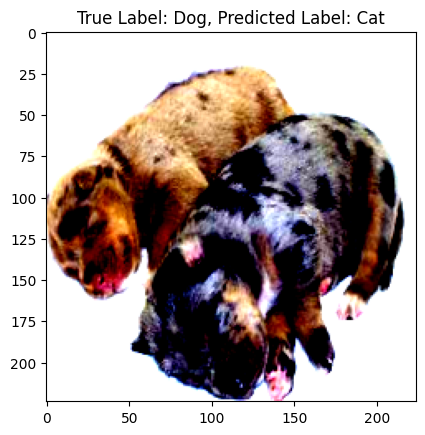

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 3
True Label: Cat, Predicted Label: Dog


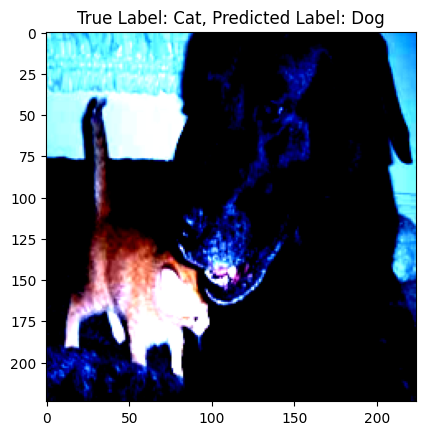

In [45]:

# Show random missed predictions on the test set without transformations
num_missed_to_show = 3
missed_predictions = []

for input_data, true_label, predicted_label in zip(test_loader.dataset, true_labels, test_predictions):
    if true_label != predicted_label:
        true_label = label_encoder.inverse_transform([true_label])[0]
        predicted_label = label_encoder.inverse_transform([predicted_label])[0]
        missed_predictions.append((input_data, true_label, predicted_label))

# Shuffle the list of missed predictions
random.shuffle(missed_predictions)

print("Random Missed Predictions:")
for i, (input_data, true_label, predicted_label) in enumerate(missed_predictions[:num_missed_to_show]):
    print(f"Sample {i + 1}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    # Display the original image for missed predictions without transformations
    input_data = input_data[0]  # Assuming the input data is the first element of the tuple
    plt.figure()
    plt.imshow(input_data.numpy().transpose((1, 2, 0)))
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.show()



Dataset Description: The dataset used in this project is called "Cats and Dogs," sourced from Kaggle. It contains a total of 25,002 images, with an equal distribution of 12,501 images for dogs and 12,501 images for cats. The dataset is primarily used for binary classification tasks, distinguishing between images of cats and dogs.

Augmentation Techniques:
For data augmentation, the following techniques were applied to the images:

Random Horizontal Flip: Images were randomly flipped horizontally. This augmentation helps the model become more robust to variations in the orientation of objects in the images.

Random Rotation: Images were randomly rotated by up to 10 degrees. This technique introduces variations in the angle of objects within the images.

Color Jittering: The brightness, contrast, saturation, and hue of images were randomly adjusted to add diversity to the dataset.

Random Grayscale: A portion (10%) of the images were randomly converted to grayscale, further increasing the variety in the dataset.

These augmentation techniques are employed to create a more diverse and extensive training dataset, which can improve the model's ability to generalize and perform well on unseen data.


Normalization: The pixel values of the images were normalized. Normalization scales the pixel values to a standardized range, typically between 0 and 1, by dividing each pixel value by 255.0 (the maximum pixel value). Normalization is performed to ensure that all the input features (pixel values) have similar scales. This aids in the training of deep neural networks and makes the optimization process more stable.

Model Description:
The model employed is a modified ResNet-18, a convolutional neural network (CNN) architecture designed for deep learning tasks. It includes several key components:

Convolutional Layers: The model commences with a convolutional layer to extract image features.

Pooling Layer: Subsequent max-pooling reduces spatial dimensions and retains essential features.

Residual Blocks: ResNet-18 utilizes residual blocks, which consist of multiple convolutional layers, batch normalization, and ReLU activations to capture complex features.

Adaptive Average Pooling: The model ends with adaptive average pooling to reduce spatial dimensions to 1x1.

Modified Classifier (Linear) Layer: For binary classification, the classifier layer has been customized. It outputs two classes (binary classification).

Changing Output Dimension:
To alter the output dimension for binary classification, the classifier layer is adjusted to output two classes.

Impact of Changing Head or Backbone:

Changing the Classifier Layer: Modifying the classifier head impacts the model's classification ability. For binary classification, it is tailored to output two classes, ensuring compatibility with the task.

Using ResNet-18 Backbone: ResNet-18, a proven architecture, serves as the model's backbone. It provides robust feature extraction capabilities.

The modifications are designed to meet the requirements of binary classification while leveraging the ResNet-18 backbone's feature extraction capabilities.

Optimizer Description:
he selected optimizer is Adam, a popular choice for training deep learning models. It is a variant of stochastic gradient descent (SGD) that incorporates momentum and adaptive learning rates. The optimizer's parameters include:

model.parameters(): This argument specifies which model parameters should be optimized during training. It essentially provides the optimizer with the model's learnable parameters.

lr=0.0001 (Learning Rate): Learning rate determines the step size during optimization. A smaller learning rate leads to more stable but slower convergence, while a larger rate may result in faster but less stable convergence. The chosen value, 0.0001, impacts the speed and stability of training.

weight_decay=0.001: Weight decay is a regularization technique that discourages large parameter values by adding a penalty term to the loss function. It helps prevent overfitting and encourages the model to generalize better.

The choice of optimizer and its hyperparameters, such as learning rate and weight decay, directly affect the training process. Optimizers like Adam adaptively adjust the learning rates for each parameter during training, making it suitable for deep neural networks. The learning rate and weight decay values are tuned based on the dataset, model architecture, and the specific loss function used in the training process.

These optimizer parameters are crucial in determining the training dynamics and overall performance of the deep learning model.






Loss Function and Regularization Description:
The chosen loss function for this task is the Cross-Entropy Loss (nn.CrossEntropyLoss). This loss function is suitable for multi-class classification problems like image classification. It quantifies the dissimilarity between predicted class probabilities and ground truth labels, facilitating the training process by driving the model to minimize classification errors.

In terms of regularization, weight decay (L2 regularization) is applied with a coefficient of 0.001 in the optimizer. Weight decay discourages excessively large weight values and mitigates overfitting, promoting better generalization to unseen data. These choices are made to ensure that the model performs well on the task while avoiding issues such as overfitting.



Loss Functions and Regularization Methods Description:

Loss Functions:

Cross-Entropy Loss (Log Loss): This is a commonly used loss function for classification tasks. It measures the dissimilarity between predicted class probabilities and actual class labels. Cross-entropy loss is especially effective for multi-class classification problems, encouraging the model to make confident and accurate predictions.

Mean Squared Error (MSE) Loss: MSE is typically used for regression tasks. It calculates the average squared difference between predicted and actual values. This loss function is useful when the task involves estimating continuous numerical values.

Regularization Methods:

L2 Regularization (Weight Decay): L2 regularization is applied to the model's weights. It discourages excessively large weight values by adding a penalty term to the loss function. This helps prevent overfitting, making the model more resilient to noise in the data.

Dropout: Dropout is a regularization technique that randomly deactivates a fraction of neurons during training. This helps prevent co-adaptation of neurons and promotes a more robust and generalizable model.

Data Augmentation: Data augmentation techniques, such as random rotations, flips, and crops, introduce variations in the training data, reducing the model's sensitivity to small input changes and improving its ability to generalize.

Early Stopping: Early stopping involves monitoring the model's performance on a validation set during training. If the performance plateaus or starts to degrade, training is halted to prevent overfitting.

Batch Normalization: Batch normalization normalizes the activations in each layer, reducing internal covariate shift. It stabilizes training, accelerates convergence, and can act as a form of regularization.

These loss functions and regularization methods are chosen based on the specific requirements of the task and the model architecture, aiming to achieve good generalization and avoid overfitting.

Results Analysis:

Overfitting and Underfitting:

In the first scenario, when using a pretrained ResNet-18 model with just the classification layer modified for binary classification (without further training), there was a test accuracy of 49.33%. This relatively low accuracy indicates that the pretrained model might be underfitting the specific task or not well-suited for binary classification.
In the second scenario, fine-tuning the pretrained model on the provided dataset led to a significant improvement in test accuracy, achieving 98.24%. This suggests that the model was able to capture the dataset's patterns and generalize well, with no signs of overfitting.
Bias and Variance:

The model trained with the dataset successfully completes the binary classification task with high accuracy. The baseline for binary classification typically consists of random guessing, which would yield an accuracy of around 50%. The model's 98.24% accuracy significantly outperforms this baseline.
Data Balance:

The dataset is well-balanced with roughly equal class distributions in the training, validation, and test sets. In the training set, there are 8747 samples for class 0 (dogs) and 8751 samples for class 1 (cats). Similarly, both the validation and test sets have balanced class distributions.
Causes of Bias:

There are several potential causes of biased output, including dataset bias, model architecture bias, and class imbalance. In this case, since the dataset is balanced, the source of bias might be attributed to dataset characteristics or model architecture. Further analysis is required to identify the precise cause of bias.
Unbiasing Methods:

To mitigate bias in a model, one can:
Collect a More Diverse Dataset: Ensuring the dataset is representative of the real-world distribution can help reduce bias.
Tune Hyperparameters: Adjusting learning rates, model architectures, or optimization algorithms can impact bias.
Regularization Techniques: Applying regularization methods like dropout and L2 regularization can help prevent overfitting and reduce bias.
Bias Detection and Mitigation: Employ techniques such as adversarial training or re-weighting samples to reduce bias.
Recognizing Missed Predictions:

To understand why the model might have made missed predictions, a comprehensive error analysis is needed. Investigate the specific images, classes, and contexts where the model tends to make errors. This analysis can reveal areas for improvement in data collection, model architecture, or preprocessing.
Improvement Strategies:

To further enhance the model's performance, consider:
Collecting additional data to increase diversity.
Experimenting with different model architectures or ensembling methods.
Applying more advanced regularization techniques.
Investigating and addressing any systematic bias in the dataset.
Using state-of-the-art techniques like transfer learning with larger pretrained models.
The significant improvement in test accuracy from 49.33% to 98.24% demonstrates the efficacy of fine-tuning the pretrained model, suggesting that further optimization and data-related improvements could lead to even better results.



